In [1]:
import os

import numpy as np
import pandas as pd

from csrank.callbacks import DebugOutput
from csrank.constants import OBJECT_RANKING
from csrank.fate_ranking import FATEObjectRanker
from csrank.util import rename_file_if_exist, configure_logging_numpy_keras, get_tensor_value, create_dir_recursively, tensorify,scores_to_rankings
from keras.utils import plot_model
from keras import backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pandas as pd
from csrank.losses import *
from csrank.metrics import *
from csrank.dataset_reader import SyntheticDatasetGenerator
from sklearn.utils import check_random_state
from collections import OrderedDict

ModuleNotFoundError: No module named 'bordarank'

In [2]:
ranking_metrics = OrderedDict(
    {'KendallsTau': kendalls_tau_for_scores, 'SpearmanCorrelation': spearman_correlation_for_scores,
     'ZeroOneRankLoss': zero_one_rank_loss_for_scores,
     'ZeroOneRankLossTies': zero_one_rank_loss_for_scores_ties, "ZeroOneAccuracy": zero_one_accuracy_for_scores})
ERROR_OUTPUT_STRING = 'Out of sample error %s : %0.4f'

In [3]:
SUB_FOLDER = "gr_vis"
MODEL = "aModel"
log_path = os.path.join(os.getcwd(), SUB_FOLDER, "gr.log")

In [4]:
def generate_medoid_dataset(n_objects = 3, n_features = 2, random_state=42, **kwargs):
    n_features = n_features
    n_train_instances = 100
    n_test_instances = 6
    n_objects = n_objects
    random_state = check_random_state(random_state)
    params = {'n_train_instances': n_train_instances, 'n_test_instances': n_test_instances, 'n_features': n_features,
              'n_objects': n_objects,
              'random_state': random_state}
    or_generator = SyntheticDatasetGenerator(**params)
    return or_generator.get_single_train_test_split() 

In [5]:
def get_evaluation_result(gor, X_train, Y_train, X_test, Y_test):
    gor.fit(X_train, Y_train, log_callbacks=[DebugOutput()], epochs=epochs)
    y_pred_scores = gor.predict_scores(X_test, batch_size=X_test.shape[0])
    dict1 = {}

    for name, evaluation_metric in ranking_metrics.items():
        metric_loss = get_tensor_value(evaluation_metric(Y_test, y_pred_scores))
        logger.info(ERROR_OUTPUT_STRING % (name, np.mean(metric_loss)))
        dict1[name] = metric_loss
    return dict1

In [6]:
log_path = os.path.join(os.getcwd(), SUB_FOLDER, "gr.log")
log_path = rename_file_if_exist(log_path)
random_state = np.random.RandomState(seed=42)


logger = configure_logging_numpy_keras(seed=random_state.randint(2 ** 32), log_path=log_path)
logger.info(log_path)

X_train, Y_train, X_test, Y_test = generate_medoid_dataset(n_objects=5)
n_instances, n_objects, n_features = X_train.shape

epochs = 5
params = {"n_objects": n_objects, "n_object_features": n_features, "use_early_stopping": True, "use_lr_annealer": True}
logger.info(params)
n_hidden_joint_units = 5
n_hidden_set_units = 7
logger.info("n_hidden_joint_units {} and  n_hidden_set_units {}".format(n_hidden_joint_units, n_hidden_set_units))
logger.info("############################# With set layers ##############################")
gor = GeneralObjectRanker(n_hidden_joint_layers=1, n_hidden_joint_units=n_hidden_joint_units, n_hidden_set_layers=1, n_hidden_set_units=n_hidden_set_units, **params)
result = get_evaluation_result(gor, X_train, Y_train, X_test, Y_test)
result[MODEL] = "5SetLayersDefaultParams"

from keras.layers import Input, Dense
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import Lambda

def create_input_lambda(i):
    """Extracts off an object tensor from an input tensor"""
    return Lambda(lambda x: x[:, i])
X = X_test
fr = gor.set_layer.cached_models[n_objects].predict(X)
X_n = np.empty((fr.shape[0], n_objects ,fr.shape[1] + gor.n_object_features), dtype="float")
for i in range(n_objects):
    X_n[:,i] = np.concatenate((X[:,i],fr), axis=1)
X_n.shape

a,b,c = X_n.shape
input_layer_joint = Input(shape=(b,c), name="input_joint_model")
scores = []

inputs = [create_input_lambda(i)(input_layer_joint) for i in
          range(n_objects)]

for i in range(n_objects):
    joint = inputs[i]
    for j in range(len(gor.joint_layers)):
        joint = gor.joint_layers[j](joint)
    scores.append(gor.scorer(joint))
scores = concatenate(scores, name="final_scores")
gor.joint_model = Model(inputs=input_layer_joint, outputs=scores)
sc = gor.joint_model.predict(X_n)
print(sc)

In [10]:
sc = gor.predict_scores(X_test)
print(sc)
scores_to_rankings(sc)

[[ 0.58075005  0.21063901  0.5959842   0.3792968   0.49484968]
 [-0.11345228  0.0174076  -0.0043987  -0.13789582  0.39540476]
 [ 0.14866781  0.26106262 -0.10626901  0.15221033 -0.12682985]
 [ 0.43547952  0.26288944  0.23452288  0.01441877  0.02572574]
 [ 0.76837283  0.9767104   1.0261064   0.9435111   0.8211754 ]
 [ 0.3580172   0.55120325  0.35820252  0.5427103   0.26139727]]


array([[1, 4, 0, 3, 2],
       [3, 1, 2, 4, 0],
       [2, 0, 3, 1, 4],
       [0, 1, 2, 4, 3],
       [4, 1, 0, 2, 3],
       [3, 0, 2, 1, 4]])

In [11]:
sc = gor.model.predict(X_test)
print(sc)
scores_to_rankings(sc)

[[ 0.58075005  0.21063901  0.5959842   0.3792968   0.49484968]
 [-0.11345228  0.0174076  -0.0043987  -0.13789582  0.39540476]
 [ 0.14866781  0.26106262 -0.10626901  0.15221033 -0.12682985]
 [ 0.43547952  0.26288944  0.23452288  0.01441877  0.02572574]
 [ 0.76837283  0.9767104   1.0261064   0.9435111   0.8211754 ]
 [ 0.3580172   0.55120325  0.35820252  0.5427103   0.26139727]]


array([[1, 4, 0, 3, 2],
       [3, 1, 2, 4, 0],
       [2, 0, 3, 1, 4],
       [0, 1, 2, 4, 3],
       [4, 1, 0, 2, 3],
       [3, 0, 2, 1, 4]])

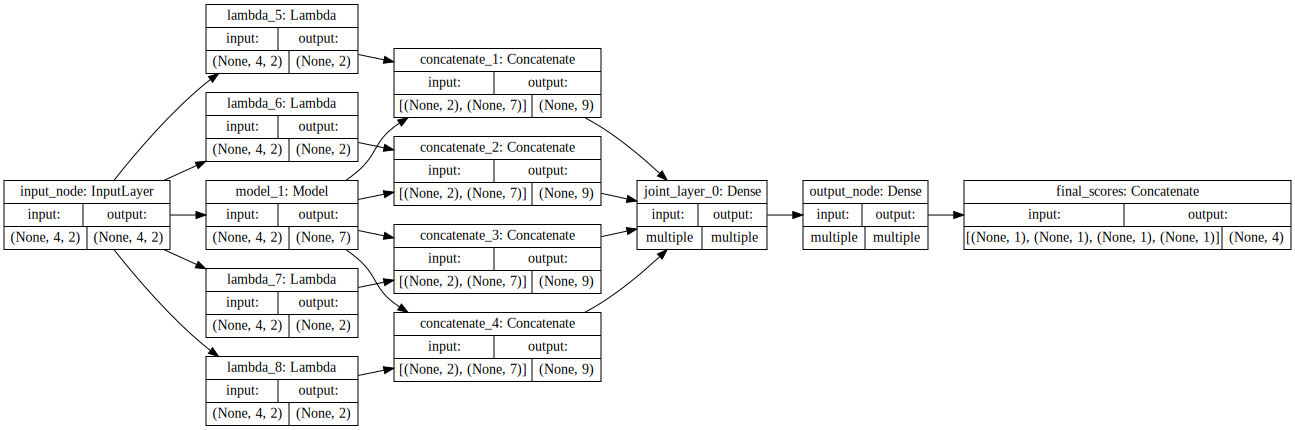

In [12]:
SVG(model_to_dot(gor.model, show_shapes=True, rankdir='LR').create(prog='dot', format='svg'))

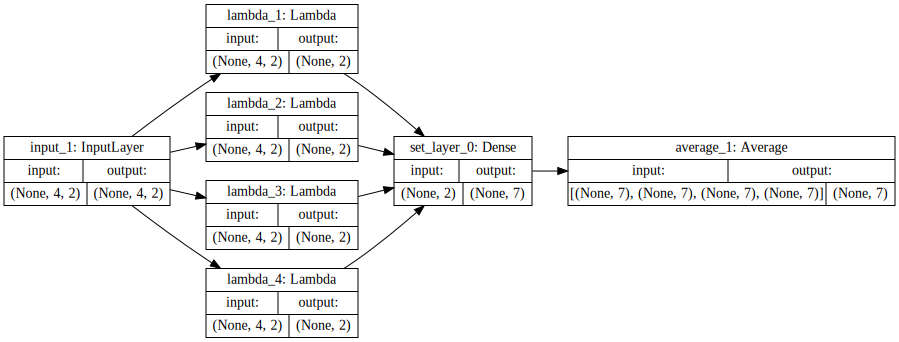

In [8]:
SVG(model_to_dot(gor.set_layer.cached_models[n_objects], show_shapes=True, rankdir='LR').create(prog='dot', format='svg'))

[[0. 3. 1. 2.]
 [2. 1. 0. 3.]
 [3. 2. 1. 0.]
 [0. 2. 1. 3.]
 [3. 2. 1. 0.]]
[[ 0.5488345   0.26238784 -0.01644525 -0.0795784 ]
 [ 0.19476585 -0.05392584  0.48174426  0.18947001]
 [ 0.5631406   0.07619851  0.29807356 -0.09792726]
 [ 0.36222744  0.08256449  0.4053601   0.29471812]]
(4, 4)
[[ 0.5488345   0.19476585  0.5631406   0.36222744]
 [ 0.26238784 -0.05392584  0.07619851  0.08256449]
 [-0.01644525  0.48174426  0.29807356  0.4053601 ]
 [-0.0795784   0.18947001 -0.09792726  0.29471812]
 [ 0.18936673  0.148158   -0.08212394 -0.06944908]]


array([[1, 3, 0, 2],
       [0, 3, 2, 1],
       [3, 0, 2, 1],
       [2, 1, 3, 0],
       [0, 1, 3, 2]])

In [ ]:
SVG(model_to_dot(gor.model, show_shapes=True,
                 rankdir='LR').create(prog='dot', format='svg'))

In [ ]:
SVG(model_to_dot(gor.scoring_model, show_shapes=True,
                 rankdir='LR').create(prog='dot', format='svg'))

In [12]:
logger.info("Actual Model")
for x in gor.model.layers:
    logger.info("Layer {}".format(x.name))
    try:
        logger.info(np.array(x.get_weights()[0]).shape)
        logger.info(x.get_weights())
        logger.info(x.input_shape)
        logger.info(x.output_shape)
    except IndexError:
        logger.info("Empty")
logger.info(gor.model.layers[-1].output.get_shape())

In [13]:
logger.info("Scoring Model")

for x in gor.scoring_model.layers:
    logger.info("Layer {}".format(x.name))
    try:
        logger.info(np.array(x.get_weights()[0]).shape)
        logger.info(x.get_weights())
        logger.info(x.input_shape)
        logger.info(x.output_shape)
    except IndexError:
        logger.info("Empty")
logger.info(gor.model.layers[-1].output.get_shape())

In [14]:
model_path = os.path.join(os.getcwd(), SUB_FOLDER, "completeModel.png")
plot_model(plot_model(gor.model,to_file=model_path,show_shapes=True,
                 rankdir='LR'))


AttributeError: 'NoneType' object has no attribute 'layers'

In [15]:
model_path = os.path.join(os.getcwd(), SUB_FOLDER, "setModel.png")
plot_model(plot_model(gor.set_layer.model,to_file=model_path,show_shapes=True,
                 rankdir='LR'))

AttributeError: 'NoneType' object has no attribute 'layers'